In [99]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import learning_curve, KFold, GridSearchCV



# Librerías adicionales
import itertools  # Para generar combinaciones de columnas
import matplotlib.patches as mpatches  # Para manejar gráficos

# Importación de módulo personalizado
import payments_manager as pm

# Inicialización del proyecto (si es necesario)
# pm.help()  # Si se necesita ayuda del módulo
# pm.reset()  # Para reiniciar cualquier configuración anterior
# pm.init()  # Si es necesario inicializar el módulo con opciones (por ejemplo, debug=True)

# Cargar y preparar el DataFrame df_jo
df_jo = pm.df('df_jo')  # Cargar el DataFrame desde 'payments_manager'
df_jo.info()  # Ver información básica sobre el DataFrame

# Ordenar el DataFrame df_jo por la columna 'id_cr' y resetear índices
df_jo = df_jo.sort_values(by=["id_cr"]).reset_index(drop=True)

# Crear una copia del DataFrame para su posterior uso
df_jo_cp = df_jo.copy()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [100]:
# PASAJE DE CATEGORICAS A NUMERICAS

# Reasignar valores en la columna 'transfer_type'
df_jo_cp['transfer_type'] = df_jo_cp['transfer_type'].map({'regular': 0, 'instant': 1})
df_jo_cp['charge_moment'] = df_jo_cp['charge_moment'].map({'before': 0, 'after': 1})

In [101]:
# SEGMENTACIONES EN DATAFRAMES REPETITIVOS Y NUEVOS

# Ordenar por 'created_at' para asegurar que la primera acción esté en la parte superior
df_jo_cp_sorted = df_jo_cp.sort_values('created_at')
count_all = df_jo_cp_sorted.shape[0]

# 2. Identificar usuarios con más de una acción (usuarios repetitivos)

repeat_users_df = df_jo_cp[(df_jo_cp['n_fees'] > 1) | (df_jo_cp['n_backs'] > 1) | (df_jo_cp['n_recovery'] > 1) | (df_jo_cp['n_inc_back'] > 1)| (df_jo_cp['n_inc_fees'] > 1)]

# Sort and group by user_id, keeping repetitive activities
repeat_users_df = repeat_users_df.sort_values('created_at').reset_index(drop=True)

# Obtener los usuarios nuevos (aquellos con solo una acción)

new_users_df = df_jo_cp[(df_jo_cp['n_fees'] <= 1) & (df_jo_cp['n_backs'] <= 1) & (df_jo_cp['n_recovery'] <= 1) & (df_jo_cp['n_inc_back'] <= 1) & (df_jo_cp['n_inc_fees'] <= 1)]


new_users_df = new_users_df.sort_values('created_at').groupby('user_id').first().reset_index()

# Número de filas de nuevos usuarios
count_new_users = new_users_df.shape[0]

# Número de filas de usuarios repetitivos
count_repeat_users = repeat_users_df.shape[0]

# Imprimir resultados
print(f'Número de filas en el DataFrame original: {count_all}')
print(f'Número de filas en el DataFrame de nuevos usuarios: {count_new_users}')
print(f'Número de filas en el DataFrame de usuarios repetitivos: {count_repeat_users}')





Número de filas en el DataFrame original: 32092
Número de filas en el DataFrame de nuevos usuarios: 11938
Número de filas en el DataFrame de usuarios repetitivos: 18808


In [102]:
#VERIFICACION DE BALANCEO DE CLASES

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts_all = df_jo_cp['needs_m_check_recov'].value_counts()
value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total_all = value_counts_all[0] + value_counts_all[1]
total_new = value_counts_new[0] + value_counts_new[1]
total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual_all = (value_counts_all[1] / total_all) * 100
needs_manual_new = (value_counts_new[1] / total_new) * 100
needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')

Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
Porcentaje de operaciones con needs_m_check del clientes nuevos: 43.72 %
Porcentaje de operaciones con needs_m_check del clientes repetitivos: 57.83 %


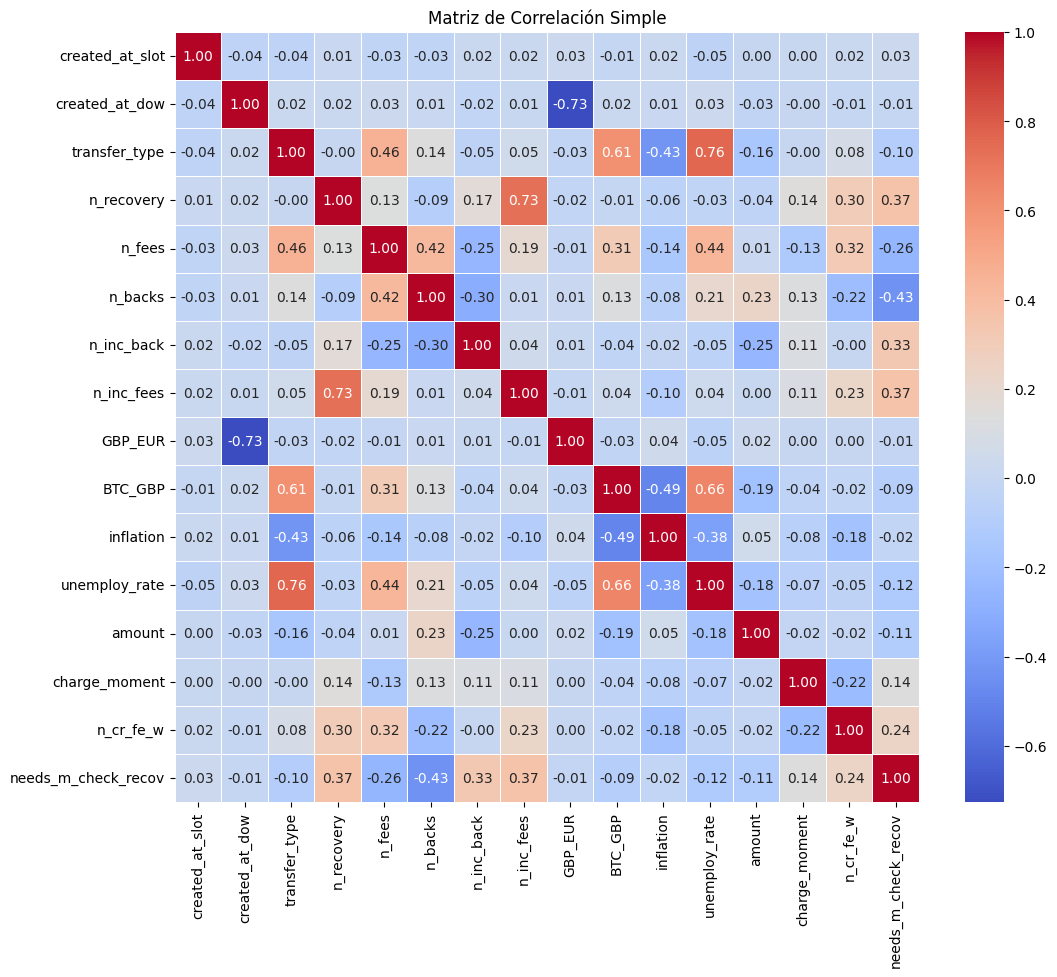

In [131]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type','n_recovery', 'n_fees', 'n_backs','n_inc_back','n_inc_fees','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment','n_cr_fe_w','needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
#df_simpl = df_jo_cp_sorted[columnas_deseadas]
#df_simpl = new_users_df[columnas_deseadas]
df_simpl = repeat_users_df[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()


In [141]:
# BALANCEO DE CARGAS

columns = df_simpl.columns
X_b = df_simpl.drop('needs_m_check_recov', axis=1)
y_b = df_simpl['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

columns_X = np.delete(columns, 15)
columns_y = columns[-1]

print(pd.Series(y_under).value_counts())

X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])

balanced_df = pd.concat([X_b_df, y_b_df], axis=1)


needs_m_check_recov
0    7931
1    7931
Name: count, dtype: int64


In [142]:
# NORMALIZACION Y ESCALADO

# Eliminar las columnas no necesarias del DataFrame
X_s = balanced_df.drop(columns=[
    'needs_m_check_recov',
])

# Definir la variable objetivo
Y_s = balanced_df['needs_m_check_recov']

# Aplicar StandardScaler para la normalización
s_scaler = StandardScaler()
X_s_scaled = s_scaler.fit_transform(X_s)

# Convertir el array escalado de nuevo a DataFrame y restaurar los nombres de las columnas
X_s_scaled = pd.DataFrame(X_s_scaled, columns=X_s.columns)

# Imprimir las formas de los datos
print(X_s_scaled.shape)
print(Y_s.shape)

(15862, 15)
(15862,)


In [143]:
# PREPARACION DE CARACTERISTICAS Y ETIQUETA PARA MODELOS

# Crea la matriz de características y la var objetivo
#X = df_simpl.drop(columns=[
#    'needs_m_check_recov',  
    #'created_at_slot',      
    #'created_at_dow',       
    #'transfer_type',
    #'n_fees',
    #'n_backs',
    #'n_inc_back',
    #'n_inc_fees',
    #'GBP_EUR',
    #'BTC_GBP',
    #'inflation',      
    #'unemploy_rate',
    #'amount',
    #'charge_moment"
    #'n_recovery"
#])

X = X_s.drop(columns=[
    #  'created_at_slot',      
    #  'created_at_dow',       
    #  'transfer_type',
    #  'n_fees',
    #  'n_backs',
    #  'n_inc_back',
    #  'n_inc_fees',
    #  'GBP_EUR',
    #  'BTC_GBP',
    #  'inflation',      
    #  'unemploy_rate',
    #  'amount',
    #  'charge_moment'
    #  'n_recovery"
])

#y = df_simpl['needs_m_check_recov'] # La columna de la variable objetivo
y = Y_s

X.fillna(0, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15862 entries, 9 to 15590
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   created_at_slot  15862 non-null  int32  
 1   created_at_dow   15862 non-null  int32  
 2   transfer_type    15862 non-null  int64  
 3   n_recovery       15862 non-null  int64  
 4   n_fees           15862 non-null  int64  
 5   n_backs          15862 non-null  int64  
 6   n_inc_back       15862 non-null  int64  
 7   n_inc_fees       15862 non-null  int64  
 8   GBP_EUR          15862 non-null  float64
 9   BTC_GBP          15862 non-null  float64
 10  inflation        15862 non-null  float64
 11  unemploy_rate    15862 non-null  float64
 12  amount           15862 non-null  float64
 13  charge_moment    15862 non-null  float64
 14  n_cr_fe_w        15862 non-null  float64
dtypes: float64(7), int32(2), int64(6)
memory usage: 1.8 MB


In [155]:
# MODELO DE ÁRBOL DE DECISIÓN/RANDOM FOREST

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Árbol de Decisión
#DT = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=None)
RF = RandomForestClassifier(
    n_estimators=200,            # Número de árboles en el bosque
    max_depth=16,              # Profundidad máxima de los árboles
    min_samples_split=10,         # Mínimo número de muestras requeridas para dividir un nodo interno
    min_samples_leaf=1,          # Mínimo número de muestras requeridas en una hoja
    max_features='sqrt',         # Número máximo de características consideradas en cada división 
    class_weight='balanced',     # Ajusta automáticamente los pesos para manejar el desbalanceo de clases
    criterion='entropy',            # Métrica para medir la calidad de las divisiones
    bootstrap=True,              # Usa muestreo con reemplazo para construir cada árbol
    random_state=42,             # Semilla para reproducibilidad de resultados
    oob_score=True               # Activa la estimación de rendimiento con datos fuera de la bolsa (out-of-bag)
)


# Entrenar el modelo con el conjunto de datos de entrenamiento
#DT.fit(X_train, y_train)
RF.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
#predictions = DT.predict(X_test)
predictions = RF.predict(X_test)



In [156]:
# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': RF.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

            Feature  Importance
14        n_cr_fe_w    0.223985
7        n_inc_fees    0.203234
3        n_recovery    0.134393
5           n_backs    0.134270
6        n_inc_back    0.067458
4            n_fees    0.053942
13    charge_moment    0.053565
9           BTC_GBP    0.028324
8           GBP_EUR    0.017487
11    unemploy_rate    0.017206
2     transfer_type    0.016674
0   created_at_slot    0.016539
10        inflation    0.012903
12           amount    0.010544
1    created_at_dow    0.009474


Precisión del modelo: 0.9565

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1569
           1       0.95      0.96      0.96      1604

    accuracy                           0.96      3173
   macro avg       0.96      0.96      0.96      3173
weighted avg       0.96      0.96      0.96      3173


Importancia de las características (ordenadas por magnitud):
n_cr_fe_w: 0.2240
n_inc_fees: 0.2032
n_recovery: 0.1344
n_backs: 0.1343
n_inc_back: 0.0675
n_fees: 0.0539
charge_moment: 0.0536
BTC_GBP: 0.0283
GBP_EUR: 0.0175
unemploy_rate: 0.0172
transfer_type: 0.0167
created_at_slot: 0.0165
inflation: 0.0129
amount: 0.0105
created_at_dow: 0.0095


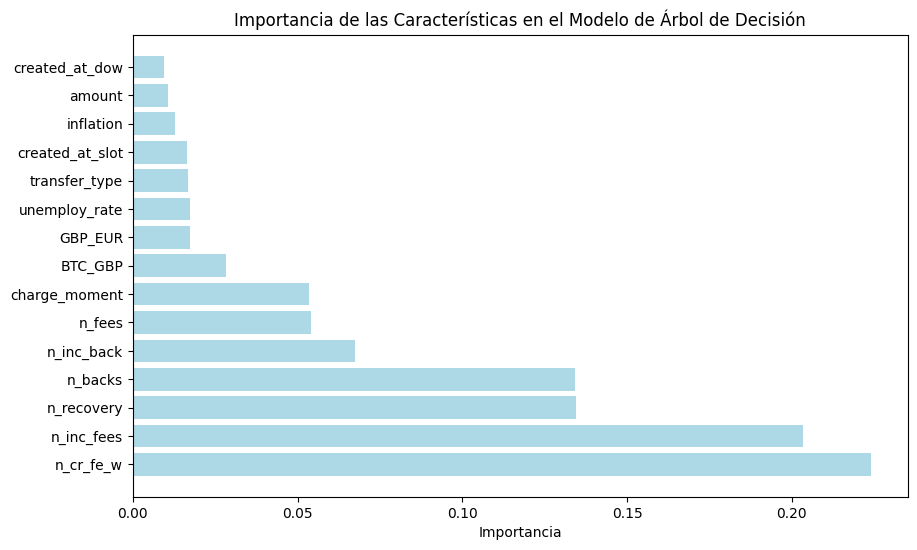

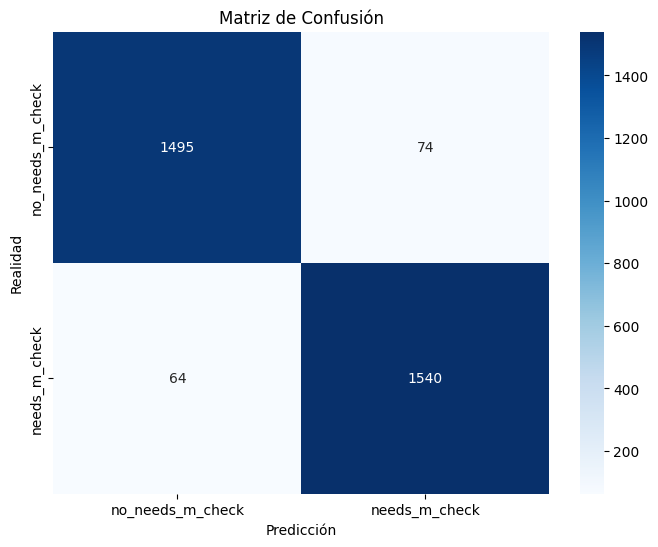

In [157]:
# EVALUACION DEL RENDIMIENTO DEL MODELO

# 1. Precisión del modelo
accuracy = RF.score(X_test, y_test)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(y_test, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = RF.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
# Graficar las importancias de las características (ordenadas)
features = [f[0] for f in feature_importance_sorted]
importances = [f[1] for f in feature_importance_sorted]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()


Total de muestras: 300
300


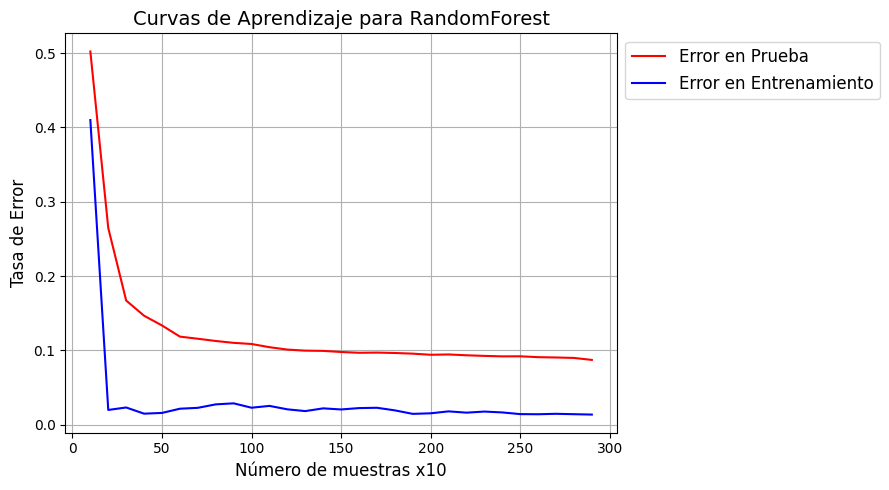

In [160]:
# Graficar curvas de error. 

np.random.seed(42)
# Parámetros
MAXN = 300 #len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        RF = RandomForestClassifier(
            n_estimators=200,            # Número de árboles en el bosque
            max_depth=13,              # Profundidad máxima de los árboles
            min_samples_split=10,         # Mínimo número de muestras requeridas para dividir un nodo interno
            min_samples_leaf=1,          # Mínimo número de muestras requeridas en una hoja
            max_features='sqrt',         # Número máximo de características consideradas en cada división 
            class_weight='balanced',     # Ajusta automáticamente los pesos para manejar el desbalanceo de clases
            criterion='entropy',            # Métrica para medir la calidad de las divisiones
            bootstrap=True,              # Usa muestreo con reemplazo para construir cada árbol
            random_state=42,             # Semilla para reproducibilidad de resultados
            oob_score=True               # Activa la estimación de rendimiento con datos fuera de la bolsa (out-of-bag)
        )
        RF.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1- metrics.accuracy_score(RF.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(RF.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para RandomForest', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()

 



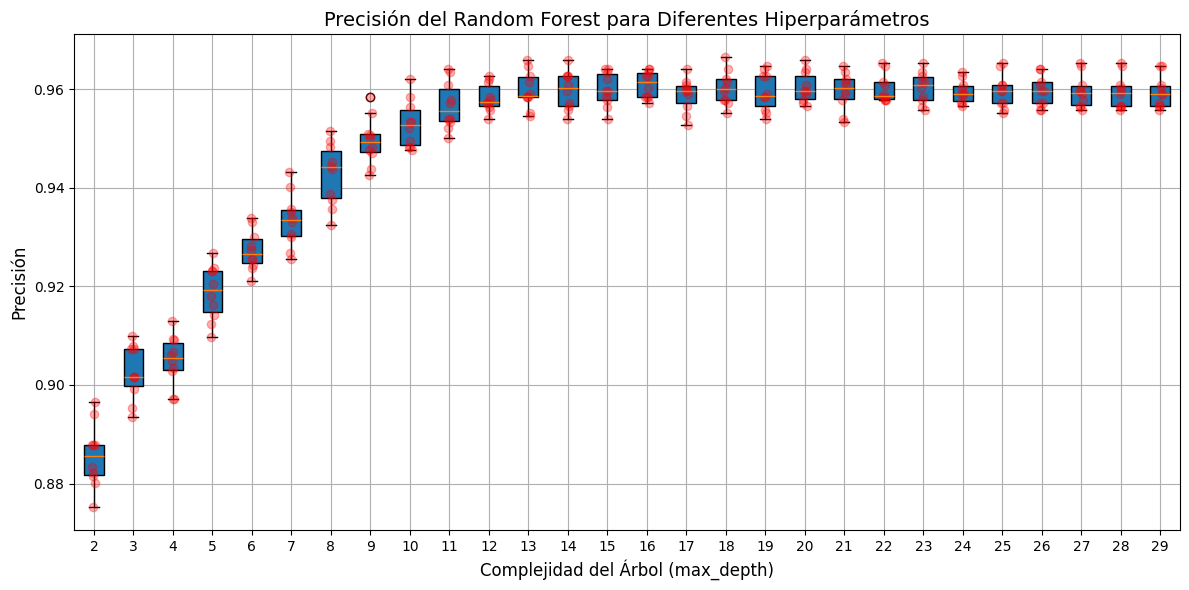

In [152]:
X_np = X.to_numpy()
y_np = y.to_numpy()

# Configurar la validación cruzada de 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir los hiperparámetros a evaluar
C = np.arange(2, 30)

# Matriz para almacenar las precisiones
results = np.zeros((10, len(C)))

# Iterar sobre los pliegues y los hiperparámetros
for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]
    for i, c in enumerate (C):

        RF = RandomForestClassifier(
            n_estimators=200,            # Número de árboles en el bosque
            max_depth=c,              # Profundidad máxima de los árboles
            min_samples_split=10,         # Mínimo número de muestras requeridas para dividir un nodo interno
            min_samples_leaf=1,          # Mínimo número de muestras requeridas en una hoja
            max_features='sqrt',         # Número máximo de características consideradas en cada división 
            class_weight='balanced',     # Ajusta automáticamente los pesos para manejar el desbalanceo de clases
            criterion='entropy',            # Métrica para medir la calidad de las divisiones
            bootstrap=True,              # Usa muestreo con reemplazo para construir cada árbol
            random_state=42,             # Semilla para reproducibilidad de resultados
            oob_score=True               # Activa la estimación de rendimiento con datos fuera de la bolsa (out-of-bag)
        )

        # Entrenar el modelo
        RF.fit(X_train, y_train)

        # Predecir resultados
        y_pred = RF.predict(X_val)

        # Calcular y almacenar la precisión
        results[fold, i] = accuracy_score(y_val, y_pred)

# Graficar los resultados
plt.figure(figsize=(12, 6))

plt.boxplot(results, vert=True, patch_artist=True, meanline=True)

# Superponer los puntajes de precisión individuales para cada nivel de complejidad.
for i, c in enumerate(C):  # Usar el valor de C en lugar del índice.
    xderiv = (i + 1) * np.ones(results[:, i].shape) + (np.random.rand(10,) - 0.5) * 0.1
    plt.plot(xderiv, results[:, i], 'ro', alpha=0.3)  # 'ro' indica marcadores de círculo rojo.

# Establecer etiquetas para el eje x con los valores reales de C.
plt.xticks(ticks=np.arange(1, len(C) + 1), labels=C)
plt.xlabel('Complejidad del Árbol (max_depth)', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.title('Precisión del Random Forest para Diferentes Hiperparámetros', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Definir los hiperparámetros a probar y sus valores
param_grid = {
    'n_estimators': [50, 100, 200],         # Número de árboles
    'max_depth': [13],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],       # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Mínimas muestras en una hoja
    'max_features': ['sqrt', 'log2'],      # Número máximo de características para cada división
#    'class_weight': ['balanced', None]     # Peso para manejar desbalanceo
}

# Inicializar el modelo base
rf_model = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
#    cv=3,                 # Validación cruzada con 3 pliegues
    cv=10,                 # Validación cruzada con 3 pliegues
    scoring='f1_weighted',  # Utilizamos F1 ponderado como métrica de evaluación
    verbose=1,            # Mostrar el progreso
    n_jobs=-1             # Usar todos los núcleos disponibles
)

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor precisión en validación cruzada:", grid_search.best_score_)

# Entrenar el modelo con los mejores parámetros encontrados
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluar el modelo con el conjunto de prueba
y_pred = best_rf_model.predict(X_test)
print("Reporte de clasificación con parámetros ajustados:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mejor precisión en validación cruzada: 0.9378947872147269
Reporte de clasificación con parámetros ajustados:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1569
           1       0.93      0.94      0.94      1604

    accuracy                           0.94      3173
   macro avg       0.94      0.94      0.94      3173
weighted avg       0.94      0.94      0.94      3173

